In [1]:
import pandas as pd

In [5]:
df = pd.read_csv("C:/Users/User/Desktop/customer_segmentation_project/data/online_retail_II.csv")

In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [8]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


**Data Cleaning**

*Find the canceled transactions and remove them*

In [ ]:
canceled = df[df["Invoice"].astype(str).str.startswith("C")]
canceled.shape[0]

19494

In [13]:
df = df[~df["Invoice"].astype(str).str.startswith('C')]

*Find the rows with missing Customer ID and remove them*

In [19]:
num_missing = df["Customer ID"].isna().sum()
print(f"Number of missing Customer IDs: {num_missing}")

Number of missing Customer IDs: 242257


In [20]:
df = df.dropna(subset=["Customer ID"])

*Remove the duplicate values*

In [ ]:
df = df.drop_duplicates()

*Convert **InvoiceDate** to datetime*

In [21]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [24]:
df["InvoiceDate"].dtype

dtype('<M8[ns]')

**Feature Engineering**

*Creating RFM features*

In [26]:
# Snapshot date: one day after last invoice
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

In [28]:
rfm = df.groupby("Customer ID").agg({
  "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
  "Invoice": "nunique",
  "Price": "sum"  
})

rfm.rename(columns={
    'InvoiceDate': "Recency",
    "Invoice": "Frequency",
    "Price": "Monetary"
}, inplace=True)

In [29]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,207.40
12347.0,2,8,644.16
12348.0,75,5,193.10
12349.0,19,4,1480.44
12350.0,310,1,65.30


**Handling Outliers**

In [30]:
import numpy as np

rfm["Monetary"] = np.where(
    rfm["Monetary"] > rfm["Monetary"].quantile(0.99),
    rfm["Monetary"].quantile(0.99),
    rfm["Monetary"]
)

**K-Means**

*Scaling Features for K-Means*

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

*Applying Elbow Method to decide the optimal number of clusters*

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [34]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

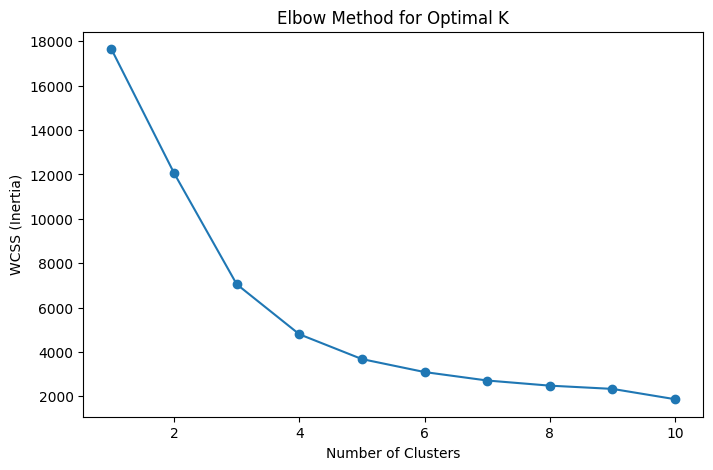

In [35]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()

*Applying Silhouette Score method yto decide the optimal number of clusters*

In [36]:
from sklearn.metrics import silhouette_score

In [37]:
for k in range(2, 11):
    kmeans= KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"Number of clusters: {k}, Silhouette Score: {score:.3f}")

Number of clusters: 2, Silhouette Score: 0.455
Number of clusters: 3, Silhouette Score: 0.529
Number of clusters: 4, Silhouette Score: 0.543
Number of clusters: 5, Silhouette Score: 0.525
Number of clusters: 6, Silhouette Score: 0.481
Number of clusters: 7, Silhouette Score: 0.444
Number of clusters: 8, Silhouette Score: 0.432
Number of clusters: 9, Silhouette Score: 0.408
Number of clusters: 10, Silhouette Score: 0.409


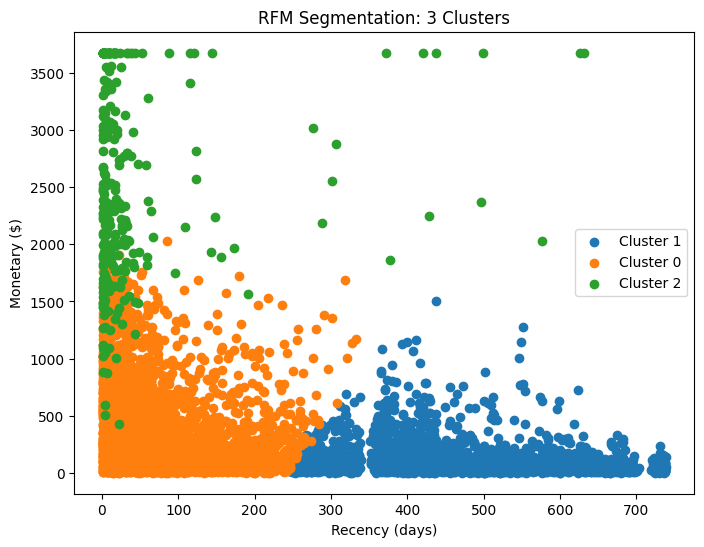

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
kmeans3 = KMeans(n_clusters=3, random_state=42)
rfm['Cluster_3'] = kmeans3.fit_predict(rfm_scaled)
plt.figure(figsize=(8,6))
for cluster in rfm['Cluster_3'].unique():
    plt.scatter(
        rfm[rfm['Cluster_3']==cluster]['Recency'],
        rfm[rfm['Cluster_3']==cluster]['Monetary'],
        label=f'Cluster {cluster}'
    )

plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.title('RFM Segmentation: 3 Clusters')
plt.legend()
plt.show()


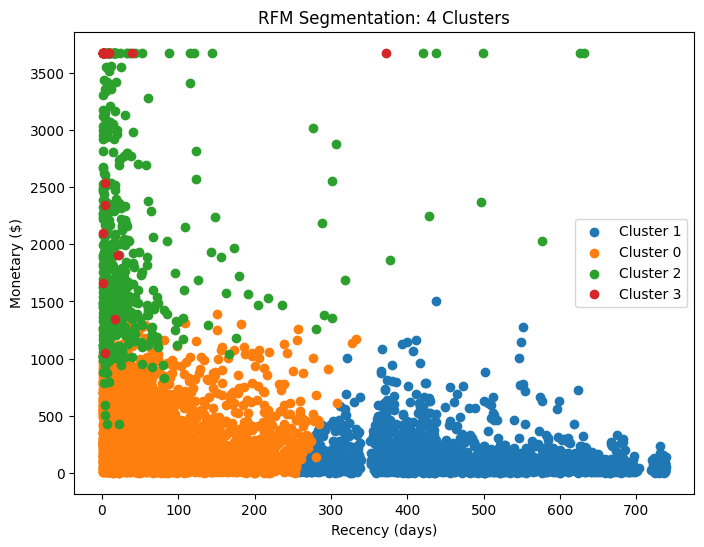

In [ ]:
kmeans4 = KMeans(n_clusters=4, random_state=42)
rfm['Cluster_4'] = kmeans4.fit_predict(rfm_scaled)
plt.figure(figsize=(8,6))
for cluster in rfm['Cluster_4'].unique():
    plt.scatter(
        rfm[rfm['Cluster_4']==cluster]['Recency'],
        rfm[rfm['Cluster_4']==cluster]['Monetary'],
        label=f'Cluster {cluster}'
    )
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.title('RFM Segmentation: 4 Clusters')
plt.legend()
plt.show()



In [40]:
print(rfm['Cluster_3'].value_counts())
print(rfm['Cluster_4'].value_counts())


Cluster_3
0    3610
1    1990
2     281
Name: count, dtype: int64
Cluster_4
0    3432
1    1953
2     475
3      21
Name: count, dtype: int64


*Selection of Number of Clusters*

The optimal number of clusters was evaluated using both the Elbow method and Silhouette analysis. The Elbow method suggested *k = 3*, while the highest Silhouette score was observed for *k = 4*. However, the fourth cluster would have included only 21 customers, making it too small to be actionable. Therefore, *k = 3* was chosen for the final RFM segmentation.

*Final Visualization of the Clusters*

In [41]:
import seaborn as sns
import matplotlib as plt

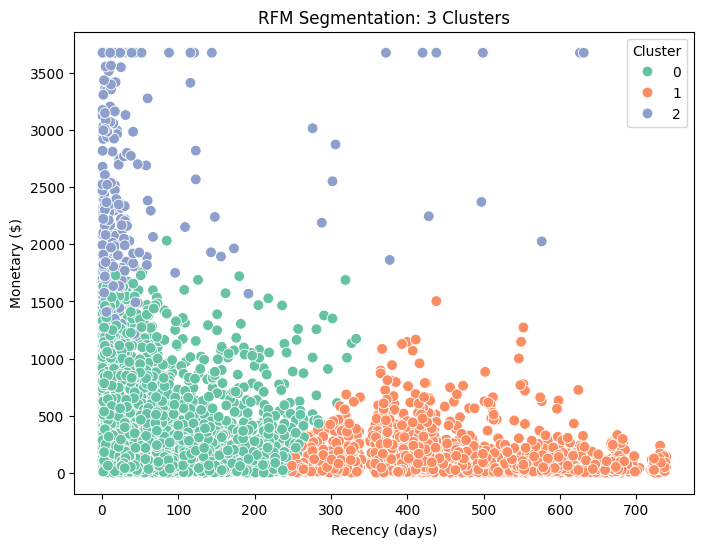

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="Cluster_3",
    palette="Set2",
    s=60
)

plt.title('RFM Segmentation: 3 Clusters')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Cluster')
plt.show()

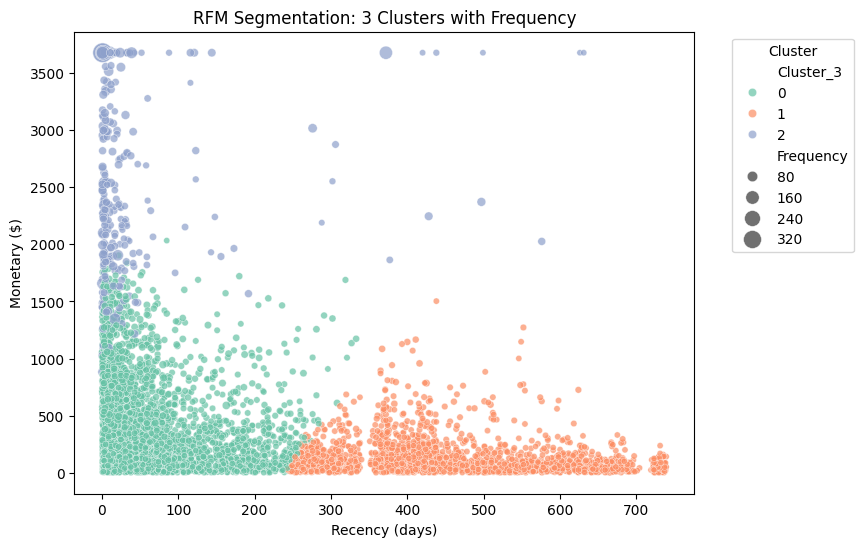

In [49]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Cluster_3',
    size='Frequency',
    sizes=(20,200),
    palette='Set2',
    alpha=0.7
)
plt.title('RFM Segmentation: 3 Clusters with Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


*Examining Cluster Profiles*

In [53]:
rfm_summary = rfm.groupby('Cluster_3').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'Cluster_3':'count'
}).rename(columns={'Cluster_3':'Count'}).reset_index()

rfm_summary


,Cluster_3,Recency,Frequency,Monetary,Count
0,0,69.885596,5.987535,365.916269,3610
1,1,462.871859,2.108040,132.285730,1990
2,2,40.466192,39.733096,2501.736733,281


*Interpretation*

Cluster 0: Recent, moderate frequency, moderate spending → Loyal customers

Cluster 1: Not recent, low frequency, low spending → At-Risk customers

Cluster 2: Very recent, very high frequency, very high spending → Champions

**We can also make clusters by calculating RFM scores.**

*Calculating RFM Scores*

In [62]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels = [5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method='first'), 5, labels = [1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm["RFM_Score"] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

In [68]:
def rfm_segment(df):
    if df['R_Score'] >= 4 and df['F_Score'] >= 4 and df['M_Score'] >= 4:
        return 'VIP'
    elif df['R_Score'] >= 3:
        return 'Loyal'
    else:
        return 'At-Risk'
    
rfm['RFM_Segment'] = rfm.apply(rfm_segment, axis=1)


*Count of Customers in Each Segment*

In [69]:
segment_counts = rfm['RFM_Segment'].value_counts()
segment_counts

RFM_Segment
At-Risk    2349
Loyal      2290
VIP        1242
Name: count, dtype: int64